In [1]:
#this notebook is to try and implement waifu images from scratch
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

Doing this training for spellbrush, goal is to recreate anime faces first using pytorch, then using JAX as well and finally try to use diffusion instead of GAN.

<img src="https://i.imgur.com/6NMdO9u.png">

There are two neural networks: a Generator and a Discriminator. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs.


<img src="https://i.imgur.com/NaKtJs0.png">
Anime Face Dataset
, which consists of over 63,000 cropped anime faces:https://www.kaggle.com/splcher/starter-anime-face-dataset


In [2]:
# setting basic setiing
dataroot = "~moutazelias/Desktop/Desktop/Github/Datasets/animefacedataset/"          # Root directory for dataset
Image_Size =64              # Number of workers for dataloader
batch_size = 128            # Batch size during training
lr = 0.0002                 # Learning rate for optimizers
num_epochs=100              # Number of training epochs
ngpu = 0                    # Number of GPUs available. Use 0 for CPU mode.


In [3]:
# Create the dataset
dataset = ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(Image_Size),
                               transforms.CenterCrop(Image_Size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

In [4]:
# Decide which device we want to run on (if i am using google colab or not)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [5]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=8).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


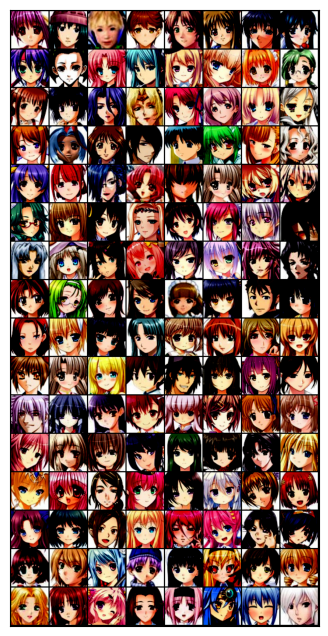

In [6]:
show_batch(dataloader)

In [7]:
#generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. ``(64*8) x 4 x 4``
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. ``(64*4) x 8 x 8``
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. ``(64*2) x 16 x 16``
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. ``(64) x 32 x 32``
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)